In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

#import matplotlib
#matplotlib.use('agg')
#import matplotlib.pyplot as plt 

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
import sys, os, math
import gezi, melt
import numpy as np

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt'
image_model_name='InceptionResnetV2'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.pointer.alignloss/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.pos'

if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name,
                                      feature_name=melt.image.get_features_name(image_model_name))
else:
  image_model = None

predictor = melt.Predictor(model_dir)

#model_dir2 = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.rnn.finetune.later'
#predictor2 = melt.Predictor(model_dir2)

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.2.0-rc0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words


ENCODE_UNK 1


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten/Reshape:0", shape=(?, 98304), dtype=float32)
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
image_model will get feature_name Conv2d_7b_1x1
image_feature: Tensor("Flatten_1/Reshape:0", shape=(?, 98304), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt


restore image var from InceptionResnetV2 /home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt duration: 3.51139593124


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.pos/model.ckpt-15.6-64000


restore meta grpah and model ok /home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.pos/model.ckpt-15.6-64000 duration: 19.8538489342


In [2]:
def predict(image_path, predictor, length_normalization_factor=1., gen_feature=True, num_show=1):
  img = melt.read_image(image_path)
  if gen_feature:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]
  #print(feature)
  timer = gezi.Timer()
  graph = predictor.graph
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          graph.get_collection('feed')[0] : feature
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          graph.get_collection('feed')[0] : feature,
                                          graph.get_collection('beam_search_input_feed')[0] : input_feed,
                                          graph.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=ids2text.end_id(), 
                                   max_words=decode_max_words, 
                                   length_normalization_factor=length_normalization_factor)


  for i, beam in enumerate(beams):
    print(i, beam.words)
    print(i, ids2text.ids2text(beam.words), math.exp(beam.score))

    # Plot images with attention weights
    words = beam.words    
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 1:  
      for j in range(len(words)):
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(ids2text.vocab.key(words[j]).decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(beam.logprobs[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(beam.alignments_list[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(beam.alignments_list[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    #print('beam search using time(ms):', timer.elapsed_ms())

In [3]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

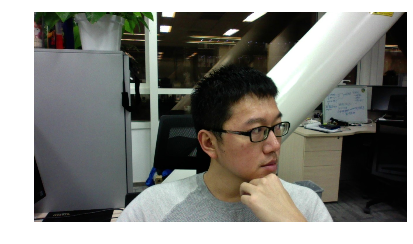

0 [10, 43, 140, 1, 14, 33, 10, 43, 140, 1, 14, 67, 89, 21, 1, 212, 29, 9]
0 一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 坐在 房间 里 的 桌子 旁 </S> 0.639059123562


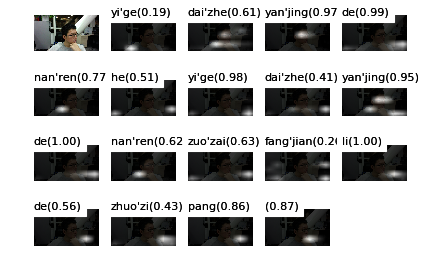

1 [10, 43, 140, 1, 14, 33, 10, 43, 140, 1, 14, 67, 89, 21, 1, 229, 5, 9]
1 一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 坐在 房间 里 的 椅子 上 </S> 0.625643546662
2 [10, 43, 140, 1, 14, 33, 10, 43, 140, 1, 14, 67, 103, 1, 212, 29, 9]
2 一个 戴着 眼镜 的 男人 和 一个 戴着 眼镜 的 男人 坐在 室内 的 桌子 旁 </S> 0.625158951934


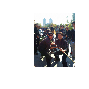

0 [156, 1, 52, 5, 11, 132, 18, 3, 680, 1, 4, 2, 53, 1673, 9]
0 平坦 的 道路 上 有 一群 拿 着 工具 的 人 在 打 曲棍球 </S> 0.604390694977


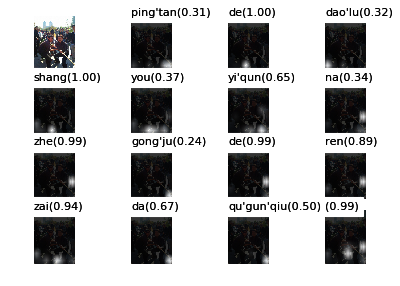

1 [156, 1, 52, 5, 11, 132, 18, 3, 2099, 1, 4, 2, 53, 1673, 9]
1 平坦 的 道路 上 有 一群 拿 着 球棍 的 人 在 打 曲棍球 </S> 0.593297880762
2 [156, 1, 52, 5, 11, 132, 18, 3, 680, 1, 4, 2, 53, 1134, 9]
2 平坦 的 道路 上 有 一群 拿 着 工具 的 人 在 打 冰壶 </S> 0.566800793953


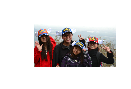

0 [10, 43, 94, 1, 14, 33, 27, 226, 18, 3, 133, 1, 4, 19, 2, 403, 5, 9]
0 一个 戴着 帽子 的 男人 和 两个 手里 拿 着 东西 的 人 站 在 沙滩 上 </S> 0.509187994388


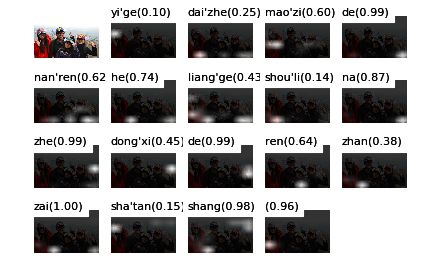

1 [10, 43, 94, 1, 14, 33, 27, 226, 18, 3, 133, 1, 4, 67, 421, 1, 229, 5, 9]
1 一个 戴着 帽子 的 男人 和 两个 手里 拿 着 东西 的 人 坐在 海边 的 椅子 上 </S> 0.481039470991
2 [10, 43, 94, 1, 14, 33, 27, 226, 18, 3, 133, 1, 4, 19, 2, 421, 1, 52, 5, 9]
2 一个 戴着 帽子 的 男人 和 两个 手里 拿 着 东西 的 人 站 在 海边 的 道路 上 </S> 0.473038724477


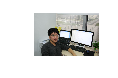

0 [89, 21, 11, 10, 43, 140, 1, 14, 2, 1238, 9]
0 房间 里 有 一个 戴着 眼镜 的 男人 在 操作电脑 </S> 0.60721933273


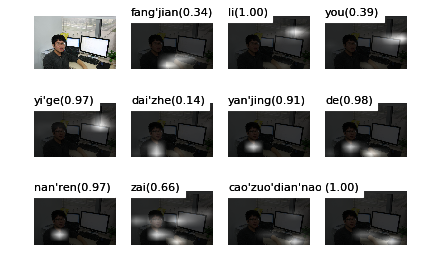

1 [89, 21, 11, 10, 20, 210, 1, 14, 2, 1238, 9]
1 房间 里 有 一个 穿着 短袖 的 男人 在 操作电脑 </S> 0.603642816267
2 [89, 21, 11, 10, 43, 140, 1, 14, 67, 229, 5, 9]
2 房间 里 有 一个 戴着 眼镜 的 男人 坐在 椅子 上 </S> 0.585844740097


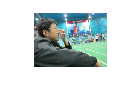

0 [104, 21, 11, 10, 43, 140, 1, 14, 2, 115, 10, 43, 140, 1, 14, 9]
0 大厅 里 有 一个 戴着 眼镜 的 男人 在 看 一个 戴着 眼镜 的 男人 </S> 0.569594572156


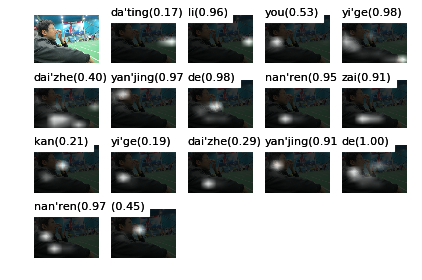

1 [104, 21, 11, 10, 43, 140, 1, 14, 2, 115, 10, 42, 18, 3, 290, 1, 14, 9]
1 大厅 里 有 一个 戴着 眼镜 的 男人 在 看 一个 右手 拿 着 笔 的 男人 </S> 0.561239512696
2 [104, 21, 11, 10, 43, 140, 1, 14, 2, 343, 9]
2 大厅 里 有 一个 戴着 眼镜 的 男人 在 下围棋 </S> 0.549980203982


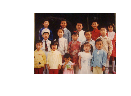

0 [273, 1, 89, 21, 19, 3, 132, 185, 1, 207, 9]
0 明亮 的 房间 里 站 着 一群 面带微笑 的 女孩 </S> 0.510298624628


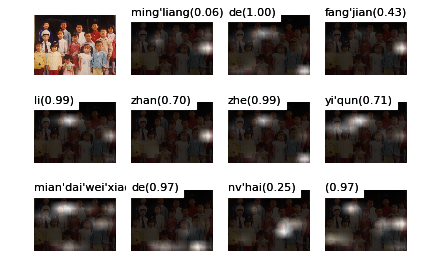

1 [273, 1, 89, 21, 19, 3, 132, 185, 1, 152, 9]
1 明亮 的 房间 里 站 着 一群 面带微笑 的 孩子 </S> 0.503455537992
2 [273, 1, 89, 21, 19, 3, 132, 20, 352, 1, 4, 9]
2 明亮 的 房间 里 站 着 一群 穿着 各异 的 人 </S> 0.475428159616


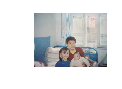

0 [89, 21, 10, 208, 2, 380, 1, 152, 75, 11, 27, 152, 67, 380, 9]
0 房间 里 一个 躺 在 床上 的 孩子 旁边 有 两个 孩子 坐在 床上 </S> 0.476693991536


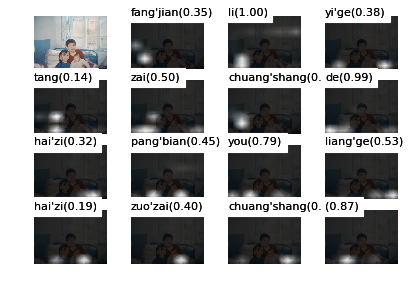

1 [89, 21, 10, 208, 2, 380, 1, 183, 75, 11, 27, 152, 67, 380, 9]
1 房间 里 一个 躺 在 床上 的 小孩 旁边 有 两个 孩子 坐在 床上 </S> 0.47490419306
2 [89, 21, 10, 208, 2, 380, 1, 152, 75, 11, 27, 152, 67, 292, 5, 9]
2 房间 里 一个 躺 在 床上 的 孩子 旁边 有 两个 孩子 坐在 沙发 上 </S> 0.461468172765


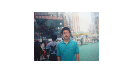

0 [27, 4, 1, 75, 11, 10, 20, 325, 90, 1, 22, 19, 2, 52, 5, 9]
0 两个 人 的 旁边 有 一个 穿着 蓝色 上衣 的 女人 站 在 道路 上 </S> 0.595643244192


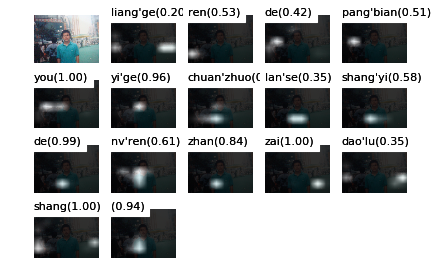

1 [27, 4, 1, 75, 11, 10, 44, 146, 316, 1, 14, 19, 2, 52, 5, 9]
1 两个 人 的 旁边 有 一个 双手 放在 身后 的 男人 站 在 道路 上 </S> 0.570757509271
2 [10, 20, 325, 90, 1, 22, 33, 10, 20, 325, 90, 1, 22, 19, 2, 382, 1, 170, 5, 9]
2 一个 穿着 蓝色 上衣 的 女人 和 一个 穿着 蓝色 上衣 的 女人 站 在 人来人往 的 街道 上 </S> 0.556576574443


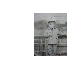

0 [10, 43, 94, 1, 14, 19, 2, 156, 1, 52, 5, 9]
0 一个 戴着 帽子 的 男人 站 在 平坦 的 道路 上 </S> 0.610453957095


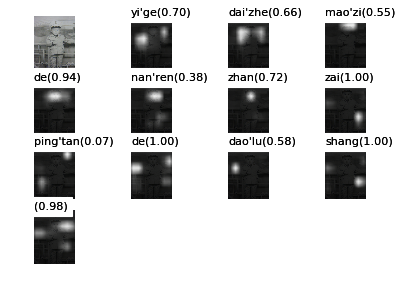

1 [10, 43, 94, 1, 14, 19, 2, 214, 1, 104, 21, 9]
1 一个 戴着 帽子 的 男人 站 在 干净 的 大厅 里 </S> 0.584246536618
2 [10, 43, 94, 1, 4, 19, 2, 214, 1, 52, 5, 9]
2 一个 戴着 帽子 的 人 站 在 干净 的 道路 上 </S> 0.576628826699


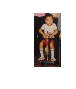

0 [65, 5, 11, 10, 44, 146, 147, 5, 1, 14, 67, 229, 5, 9]
0 舞台 上 有 一个 双手 放在 腿 上 的 男人 坐在 椅子 上 </S> 0.614401369468


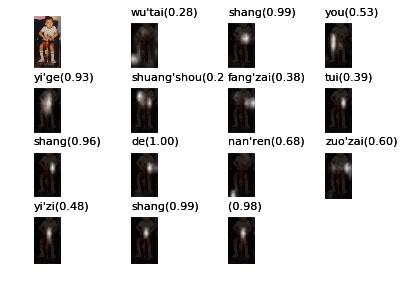

1 [65, 5, 11, 10, 44, 18, 3, 98, 1, 14, 67, 229, 5, 9]
1 舞台 上 有 一个 双手 拿 着 话筒 的 男人 坐在 椅子 上 </S> 0.610683435786
2 [65, 5, 11, 10, 44, 146, 279, 1, 14, 67, 229, 5, 9]
2 舞台 上 有 一个 双手 放在 身前 的 男人 坐在 椅子 上 </S> 0.592843711237


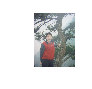

0 [10, 42, 18, 3, 1552, 1, 22, 19, 2, 597, 21, 1, 1602, 29, 9]
0 一个 右手 拿 着 剪刀 的 女人 站 在 树林 里 的 大树 旁 </S> 0.553708569735


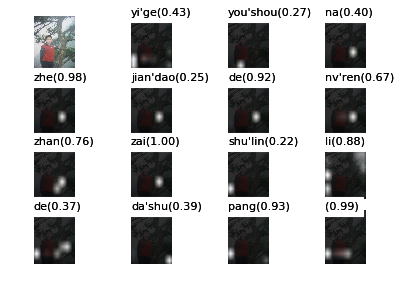

1 [10, 42, 18, 3, 1552, 1, 22, 19, 2, 597, 21, 9]
1 一个 右手 拿 着 剪刀 的 女人 站 在 树林 里 </S> 0.541403907641
2 [10, 42, 18, 3, 1552, 1, 22, 19, 2, 105, 1, 1602, 29, 9]
2 一个 右手 拿 着 剪刀 的 女人 站 在 室外 的 大树 旁 </S> 0.533637918539


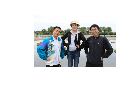

0 [70, 43, 94, 1, 14, 33, 10, 44, 18, 3, 133, 1, 22, 19, 2, 52, 5, 9]
0 三个 戴着 帽子 的 男人 和 一个 双手 拿 着 东西 的 女人 站 在 道路 上 </S> 0.538447583132


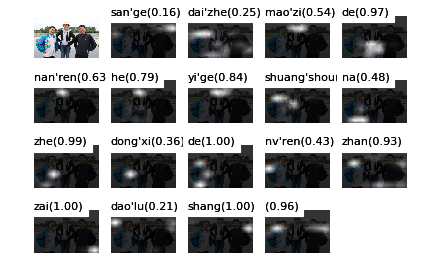

1 [70, 43, 94, 1, 14, 33, 10, 42, 18, 3, 133, 1, 22, 19, 2, 52, 5, 9]
1 三个 戴着 帽子 的 男人 和 一个 右手 拿 着 东西 的 女人 站 在 道路 上 </S> 0.536889418584
2 [70, 43, 94, 1, 14, 33, 10, 42, 18, 3, 133, 1, 14, 19, 2, 52, 5, 9]
2 三个 戴着 帽子 的 男人 和 一个 右手 拿 着 东西 的 男人 站 在 道路 上 </S> 0.525506387452


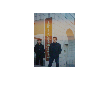

0 [10, 43, 140, 1, 14, 33, 10, 44, 123, 2, 316, 1, 14, 19, 2, 65, 5, 9]
0 一个 戴着 眼镜 的 男人 和 一个 双手 背 在 身后 的 男人 站 在 舞台 上 </S> 0.620985083151


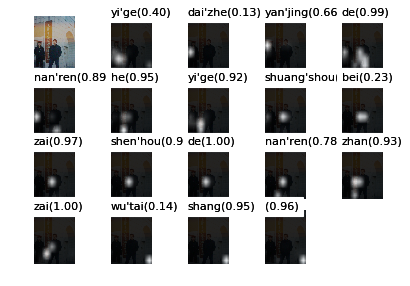

1 [10, 43, 140, 1, 14, 33, 10, 44, 123, 2, 316, 1, 14, 19, 2, 188, 32, 9]
1 一个 戴着 眼镜 的 男人 和 一个 双手 背 在 身后 的 男人 站 在 房屋 前 </S> 0.59998276439
2 [10, 43, 140, 1, 14, 33, 10, 44, 123, 2, 316, 1, 14, 19, 2, 103, 1, 251, 32, 9]
2 一个 戴着 眼镜 的 男人 和 一个 双手 背 在 身后 的 男人 站 在 室内 的 广告牌 前 </S> 0.582987630585


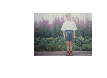

0 [10, 20, 390, 1, 14, 295, 2, 156, 1, 52, 5, 9]
0 一个 穿着 牛仔裤 的 男人 奔跑 在 平坦 的 道路 上 </S> 0.600646432345


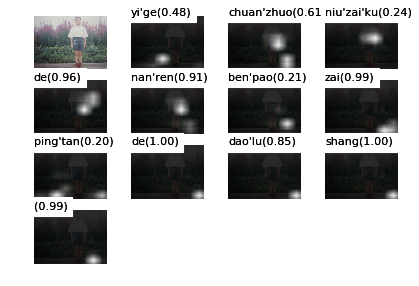

1 [10, 20, 390, 1, 14, 295, 2, 214, 1, 52, 5, 9]
1 一个 穿着 牛仔裤 的 男人 奔跑 在 干净 的 道路 上 </S> 0.578265403768
2 [10, 20, 390, 1, 14, 2, 52, 5, 538, 9]
2 一个 穿着 牛仔裤 的 男人 在 道路 上 跑步 </S> 0.557335116046


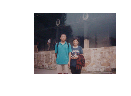

0 [10, 20, 258, 90, 1, 22, 33, 10, 44, 146, 279, 1, 14, 19, 2, 188, 64, 9]
0 一个 穿着 红色 上衣 的 女人 和 一个 双手 放在 身前 的 男人 站 在 房屋 外 </S> 0.550380687792


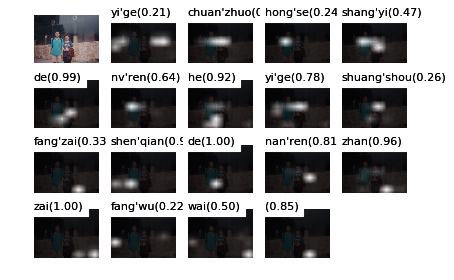

1 [10, 20, 258, 90, 1, 22, 33, 10, 20, 325, 90, 1, 14, 19, 2, 188, 64, 9]
1 一个 穿着 红色 上衣 的 女人 和 一个 穿着 蓝色 上衣 的 男人 站 在 房屋 外 </S> 0.534788209826
2 [10, 20, 258, 90, 1, 22, 33, 10, 44, 146, 279, 1, 14, 19, 2, 188, 32, 9]
2 一个 穿着 红色 上衣 的 女人 和 一个 双手 放在 身前 的 男人 站 在 房屋 前 </S> 0.529147691607


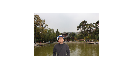

0 [10, 43, 94, 1, 14, 19, 2, 773, 1, 2620, 5, 9]
0 一个 戴着 帽子 的 男人 站 在 湖边 的 竹筏 上 </S> 0.598392396807


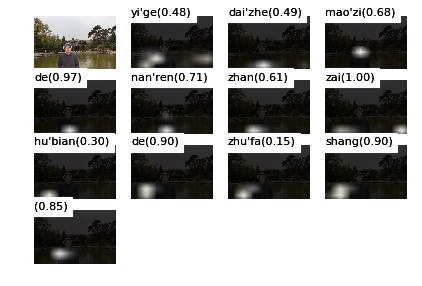

1 [10, 42, 18, 3, 2032, 1, 22, 19, 2, 773, 1, 2620, 5, 9]
1 一个 右手 拿 着 鱼竿 的 女人 站 在 湖边 的 竹筏 上 </S> 0.56843418365
2 [10, 42, 18, 3, 2032, 1, 22, 19, 2, 825, 1, 2620, 5, 9]
2 一个 右手 拿 着 鱼竿 的 女人 站 在 河边 的 竹筏 上 </S> 0.550816251267


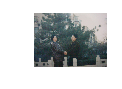

0 [10, 44, 18, 3, 133, 1, 14, 33, 10, 44, 146, 279, 1, 22, 19, 2, 105, 1, 709, 29, 9]
0 一个 双手 拿 着 东西 的 男人 和 一个 双手 放在 身前 的 女人 站 在 室外 的 护栏 旁 </S> 0.582059285024


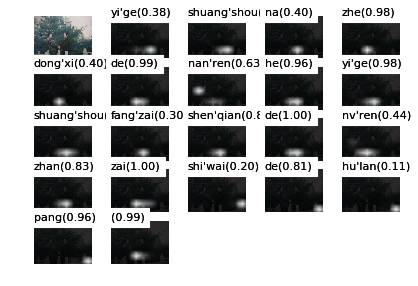

1 [10, 44, 18, 3, 133, 1, 14, 33, 10, 44, 146, 279, 1, 14, 19, 2, 105, 1, 709, 29, 9]
1 一个 双手 拿 着 东西 的 男人 和 一个 双手 放在 身前 的 男人 站 在 室外 的 护栏 旁 </S> 0.580301922121
2 [10, 44, 18, 3, 133, 1, 14, 33, 10, 44, 18, 3, 133, 1, 14, 19, 2, 105, 9]
2 一个 双手 拿 着 东西 的 男人 和 一个 双手 拿 着 东西 的 男人 站 在 室外 </S> 0.561707095268


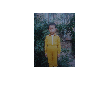

0 [10, 20, 258, 119, 1, 207, 19, 2, 188, 64, 1, 52, 5, 9]
0 一个 穿着 红色 衣服 的 女孩 站 在 房屋 外 的 道路 上 </S> 0.52042358777


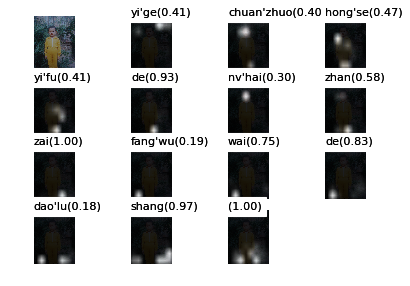

1 [10, 20, 258, 119, 1, 207, 19, 2, 105, 1, 52, 5, 9]
1 一个 穿着 红色 衣服 的 女孩 站 在 室外 的 道路 上 </S> 0.516027246634
2 [10, 20, 258, 119, 1, 152, 19, 2, 105, 1, 52, 5, 9]
2 一个 穿着 红色 衣服 的 孩子 站 在 室外 的 道路 上 </S> 0.510964724697


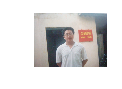

0 [10, 44, 146, 279, 1, 14, 19, 2, 587, 21, 9]
0 一个 双手 放在 身前 的 男人 站 在 教室 里 </S> 0.700489054759


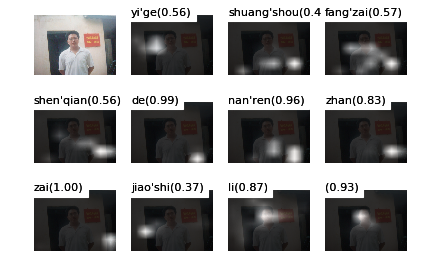

1 [587, 21, 11, 10, 44, 146, 279, 1, 14, 19, 2, 1875, 32, 9]
1 教室 里 有 一个 双手 放在 身前 的 男人 站 在 黑板 前 </S> 0.676083040338
2 [10, 20, 144, 90, 1, 14, 19, 2, 587, 21, 9]
2 一个 穿着 白色 上衣 的 男人 站 在 教室 里 </S> 0.640368419554


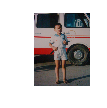

0 [52, 5, 11, 10, 20, 144, 119, 1, 22, 24, 2, 284, 29, 9]
0 道路 上 有 一个 穿着 白色 衣服 的 女人 走 在 汽车 旁 </S> 0.600286103036


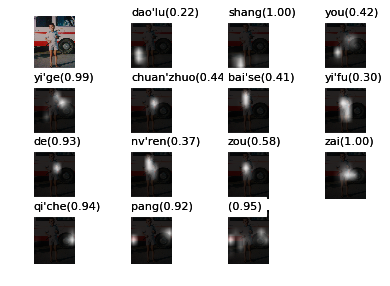

1 [52, 5, 24, 3, 10, 57, 18, 3, 133, 1, 22, 9]
1 道路 上 走 着 一个 左手 拿 着 东西 的 女人 </S> 0.561450288032
2 [52, 5, 24, 3, 10, 20, 144, 90, 1, 22, 9]
2 道路 上 走 着 一个 穿着 白色 上衣 的 女人 </S> 0.530383787856


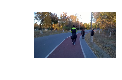

0 [156, 1, 52, 5, 11, 70, 20, 482, 1, 4, 2, 538, 9]
0 平坦 的 道路 上 有 三个 穿着 长裤 的 人 在 跑步 </S> 0.615865137147


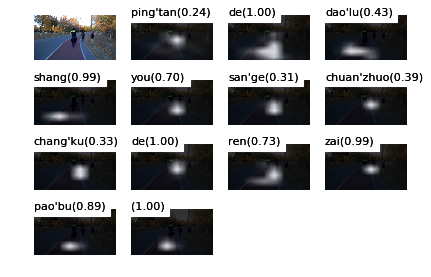

1 [156, 1, 52, 5, 11, 178, 20, 482, 1, 4, 2, 538, 9]
1 平坦 的 道路 上 有 四个 穿着 长裤 的 人 在 跑步 </S> 0.605212644329
2 [156, 1, 52, 5, 11, 27, 20, 482, 1, 4, 2, 538, 9]
2 平坦 的 道路 上 有 两个 穿着 长裤 的 人 在 跑步 </S> 0.593775122559


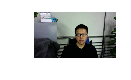

0 [10, 43, 140, 1, 14, 67, 89, 21, 1, 229, 5, 9]
0 一个 戴着 眼镜 的 男人 坐在 房间 里 的 椅子 上 </S> 0.74103696455


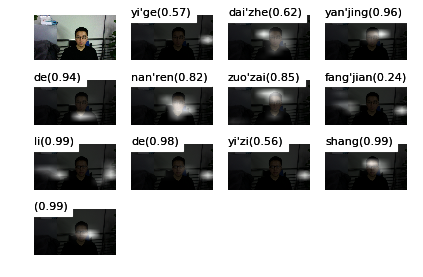

1 [10, 43, 140, 1, 14, 67, 103, 1, 212, 29, 9]
1 一个 戴着 眼镜 的 男人 坐在 室内 的 桌子 旁 </S> 0.715123058987
2 [10, 43, 140, 1, 14, 67, 103, 1, 229, 5, 9]
2 一个 戴着 眼镜 的 男人 坐在 室内 的 椅子 上 </S> 0.709372877383


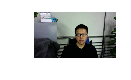

In [4]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:d61c36f810ff9f08a51cb9b5c050b657cdead4ac


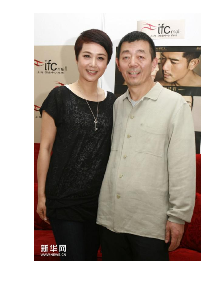

0 [10, 20, 144, 90, 1, 14, 33, 10, 20, 138, 1, 22, 19, 2, 287, 32, 9]
0 一个 穿着 白色 上衣 的 男人 和 一个 穿着 裙子 的 女人 站 在 展板 前 </S> 0.615164725765


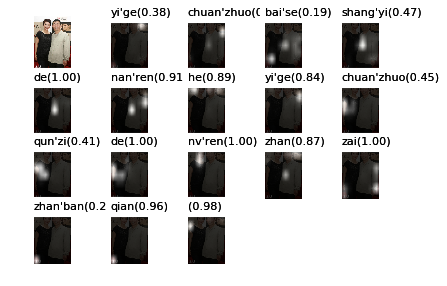

1 [10, 20, 113, 90, 1, 14, 33, 10, 20, 138, 1, 22, 19, 2, 287, 32, 9]
1 一个 穿着 黑色 上衣 的 男人 和 一个 穿着 裙子 的 女人 站 在 展板 前 </S> 0.610612416097
2 [10, 20, 144, 90, 1, 14, 33, 10, 20, 138, 1, 22, 19, 2, 251, 32, 9]
2 一个 穿着 白色 上衣 的 男人 和 一个 穿着 裙子 的 女人 站 在 广告牌 前 </S> 0.591686454433
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:b370e2570a5575db919c6a0432147d9c9eafb997


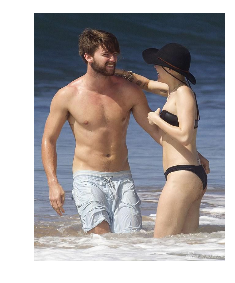

0 [10, 43, 94, 1, 14, 33, 10, 43, 94, 1, 22, 19, 2, 421, 9]
0 一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 女人 站 在 海边 </S> 0.675631724897


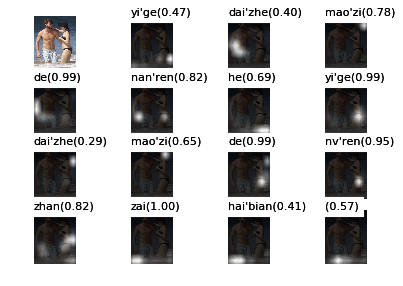

1 [10, 43, 94, 1, 14, 33, 10, 20, 1125, 1, 22, 19, 2, 421, 9]
1 一个 戴着 帽子 的 男人 和 一个 穿着 比基尼 的 女人 站 在 海边 </S> 0.674799588194
2 [10, 43, 94, 1, 14, 33, 10, 43, 94, 1, 22, 19, 2, 421, 1, 403, 5, 9]
2 一个 戴着 帽子 的 男人 和 一个 戴着 帽子 的 女人 站 在 海边 的 沙滩 上 </S> 0.663943311013
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:cac397debe8a347e1a86fd0b17f67512f8d41bf6


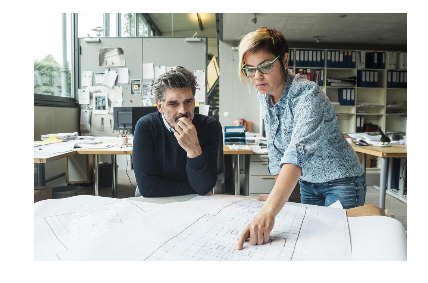

0 [1364, 21, 11, 10, 43, 140, 1, 22, 33, 10, 42, 18, 3, 235, 1, 14, 2, 221, 9]
0 办公室 里 有 一个 戴着 眼镜 的 女人 和 一个 右手 拿 着 手机 的 男人 在 交谈 </S> 0.63496102519


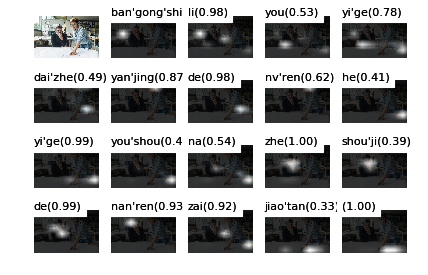

1 [89, 21, 11, 10, 43, 140, 1, 22, 33, 10, 42, 18, 3, 235, 1, 14, 2, 221, 9]
1 房间 里 有 一个 戴着 眼镜 的 女人 和 一个 右手 拿 着 手机 的 男人 在 交谈 </S> 0.632116409918
2 [1364, 21, 11, 10, 43, 140, 1, 22, 33, 10, 42, 18, 3, 235, 1, 14, 2, 115, 969, 1869, 9]
2 办公室 里 有 一个 戴着 眼镜 的 女人 和 一个 右手 拿 着 手机 的 男人 在 看 同一 本书 </S> 0.571847754637
image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:7763199d7d02eec0cabc5c05aefb5bba531ac268


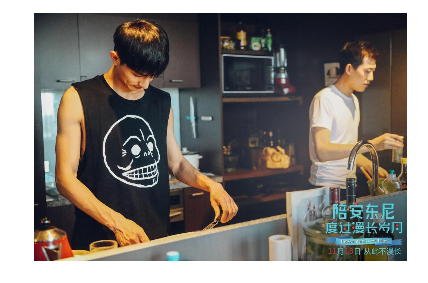

0 [89, 21, 10, 4, 1, 75, 11, 10, 43, 140, 1, 14, 33, 10, 20, 210, 1, 14, 2, 221, 9]
0 房间 里 一个 人 的 旁边 有 一个 戴着 眼镜 的 男人 和 一个 穿着 短袖 的 男人 在 交谈 </S> 0.55229977716


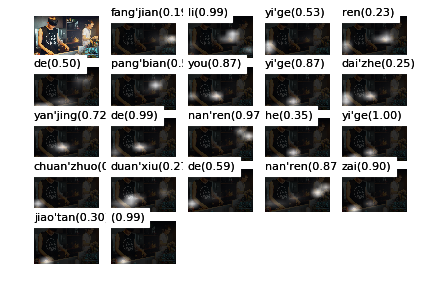

1 [89, 21, 10, 4, 1, 75, 11, 10, 43, 140, 1, 14, 33, 10, 20, 210, 1, 14, 2, 501, 9]
1 房间 里 一个 人 的 旁边 有 一个 戴着 眼镜 的 男人 和 一个 穿着 短袖 的 男人 在 握手 </S> 0.54850381106


KeyboardInterrupt: 

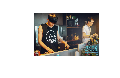

In [5]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg:')
  image_name = image_name.strip()
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'
  image_path = os.path.join(image_dir, image_name)
  
  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    continue
    
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)